---------------------------------------------------------Imports-----------------------------------------------------------------------------------------

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import time
import random
import pickle
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
from transformers import MarianMTModel, MarianTokenizer
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

from collections import Counter
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sheha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sheha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

-------------------------------------------------------------entering dataset looking at the shape and removing null values------------------------------

In [20]:
data_path = "Combined Data.csv" 
data = pd.read_csv(data_path)
print(data.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [21]:
print(data.shape)
print(data.info())
print(data.isnull().sum())

(53043, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [22]:
data = data.dropna(subset=['statement'])
print(data.shape)

(52681, 3)


In [23]:
print(data.isnull().sum())

Unnamed: 0    0
statement     0
status        0
dtype: int64


---------------------------------------------------------------visualizing dataset----------------------------------------------------------------------

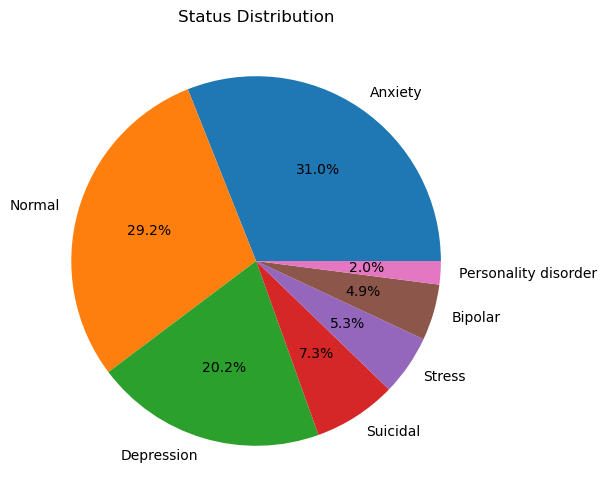

In [25]:
plt.figure(figsize=(6,6))
plt.pie(data['status'].value_counts(), labels=data['status'].unique(), autopct='%1.1f%%')
plt.title('Status Distribution')
plt.show()

In [26]:
data.isna().any()

Unnamed: 0    False
statement     False
status        False
dtype: bool

In [27]:
total_words =  ' '.join(data['statement'].values)
unique_words = set(total_words.lower().split())

print(f"Total words: {len(total_words.split())} | Unique words: {len(unique_words)}")

Total words: 5961315 | Unique words: 138966


In [28]:
word_count = pd.Series(total_words.split()).value_counts()
word_count = word_count.sort_values(ascending=False)
print(word_count)

I             319524
to            193910
and           169077
the           119388
a             115565
               ...  
thing.....         1
tumors....         1
Etc.)              1
220lbs             1
media’s            1
Name: count, Length: 154767, dtype: int64


--------------------------------------------------------- most common words-----------------------------------------------------------------------------

In [30]:
word_count[:25]

I       319524
to      193910
and     169077
the     119388
a       115565
my      109073
of       83995
i        79599
not      72618
is       68692
have     68638
it       65533
that     63173
am       60605
in       58877
me       56220
for      52059
do       51076
but      48749
just     46426
with     40212
this     37871
so       37799
was      36975
like     35917
Name: count, dtype: int64

---------------------------------------------------most uncommon words ---------------------------------------------------------------------------------

In [32]:
word_count[-25:]

*look                                        1
asthma?                                      1
sarcoma,                                     1
Capsules                                     1
lipomas                                      1
Maximize                                     1
Ashwapepper.                                 1
overwashed                                   1
https://aggripure.in/product/ashwapepper/    1
unsual                                       1
thermometer.And                              1
burning/coldish                              1
body.What                                    1
alive?Am                                     1
swallow?                                     1
stone)                                       1
facts:                                       1
27F,                                         1
gambit                                       1
Unsual                                       1
thing.....                                   1
tumors....   

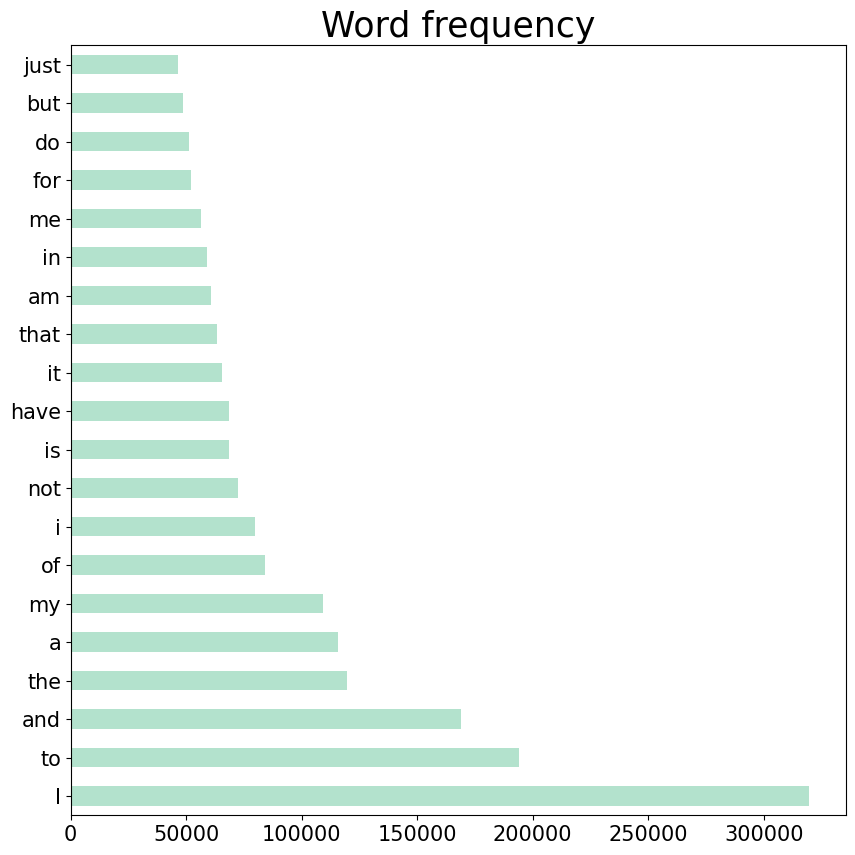

In [33]:
word_count[:20].plot.barh(figsize=(10,10),
                          fontsize=15,
                          colormap="Pastel2",
                          title="Word frequency").title.set_size(25)

----------------------------------------------------------data processing ---------------------------------------------------------------------------

In [35]:
import random
import re
import string
import pandas as pd
from nltk.corpus import wordnet 


def preprocess_text(text):
    if not isinstance(text, str):  
        return '' 
    text = text.lower()  
    text = re.sub(r'\[.*?\]', '', text)  
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = re.sub(r'<.*?>+', '', text)  
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  
    text = re.sub(r'\n', '', text) 
    text = re.sub(r'\w*\d\w*', '', text)  
    return text


def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)


def synonym_replacement(text):
    words = text.split()  
    if not words:  
        return text  
    
    new_sentence = words.copy()  
    
    
    random_word = random.choice(words)
    synonyms = get_synonyms(random_word)
    
    if synonyms: 
        synonym = random.choice(synonyms)
        new_sentence = [synonym if word == random_word else word for word in words]
    
    return ' '.join(new_sentence)


def random_swap(text, num_swaps=1):
    words = text.split()
    if len(words) <= 1:
        return text
    
    for _ in range(num_swaps):
        idx1, idx2 = random.sample(range(len(words)), 2)  
        words[idx1], words[idx2] = words[idx2], words[idx1]  
    
    return ' '.join(words)


def random_insertion(text, num_insertions=1):
    words = text.split()
    if not words: 
        return text
    
    insertions = 0
    additional_words = [
    'very', 'extremely', 'really', 'quite', 'somewhat', 'incredibly', 'barely', 'significantly',
    'absolutely', 'completely', 'totally', 'highly', 'exceptionally', 'moderately', 'almost', 'slightly',
    'undoubtedly', 'unbelievably', 'surprisingly', 'easily', 'remarkably', 'genuinely', 'noticeably', 
    'particularly', 'unusually', 'incredibly', 'fairly', 'considerably', 'strongly', 'severely',
    'incredibly', 'unquestionably', 'unusually', 'undeniably', 'truly', 'uncommonly', 'definitely',
    'mostly', 'substantially', 'largely', 'totally', 'thoroughly', 'entirely', 'absolutely', 
    'fundamentally', 'totally', 'significantly', 'deeply', 'seriously', 'intensely', 'extensively', 
    'uncommonly', 'intensely', 'vividly', 'profoundly', 'stunningly', 'fabulously', 'strikingly',
    'marvelously', 'amazingly', 'dramatically', 'staggeringly', 'astonishingly', 'exceedingly', 
    'excessively', 'irrefutably', 'unquestionably', 'very much', 'eminently', 'particularly', 
    'decidedly', 'positively', 'so', 'abnormally', 'wildly', 'immensely', 'monstrously'
]

    
    while insertions < num_insertions:
        random_position = random.randint(0, len(words) - 1) 
        word_to_insert = random.choice(additional_words)
        words.insert(random_position, word_to_insert)
        insertions += 1
    
    return ' '.join(words)


data_path = "Combined Data.csv" 
data = pd.read_csv(data_path)


print(data.isnull().sum())  

print(data.head())


data['feature'] = data['statement'].apply(lambda x: preprocess_text(x))


data['augmented_feature'] = data['feature'].apply(lambda x: synonym_replacement(x))


data['augmented_feature'] = data['augmented_feature'].apply(lambda x: random_swap(x, num_swaps=2))
data['augmented_feature'] = data['augmented_feature'].apply(lambda x: random_insertion(x, num_insertions=1))


abnormal_conditions = ['Anxiety', 'Depression', 'Stress', 'Bipolar', 'Suicidal', 'Personality Disorder']


data["label"] = data["status"].apply(lambda x: 1 if x in abnormal_conditions else 0)

print(data[['statement', 'augmented_feature', 'label']].head())


Unnamed: 0      0
statement     362
status          0
dtype: int64
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                   augmented_feature  label  
0                                severely gosh oh my      1  
1  trouble of confused judge

----------------------------------------------splitting the dataset to train ,validation,and testing ----------------------------------------------------

In [37]:
from sklearn.model_selection import train_test_split
x = data['feature']  
y = data['label'] 
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")


Training set size: 26521
Validation set size: 13261
Test set size: 13261


------------------------------------------------------vectorizing the word-------------------------------------------------------------------------------

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

custom_stop_words = ['the', 'a', 'an', 'and', 'or', 'but', 'so']  # Add common words to your stop list
vectorizer = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1, 2), max_features=5000)

# Use the defined vectorizer variable
X_train_bow = vectorizer.fit_transform(x_train)
X_val_bow = vectorizer.transform(x_val)
X_test_bow = vectorizer.transform(x_test)

# Print the shapes of the resulting matrices
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_val_bow: {X_val_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")


Shape of X_train_bow: (26521, 5000)
Shape of X_val_bow: (13261, 5000)
Shape of X_test_bow: (13261, 5000)


-------------------------------------------------------------------logistic regression------------------------------------------------------------------

-------------------------------------------------------training the model aand testing on the validation dataset----------------------------------------

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report

# Assuming X_train_bow, X_val_bow, and y_train, y_val are already defined
model = LogisticRegression(max_iter=1000, C=0.1, penalty="l2")
model.fit(X_train_bow, y_train)

# Predictions
y_val_pred = model.predict(X_val_bow)
y_val_pred_prob = model.predict_proba(X_val_bow)

# Calculate accuracy and log loss
accuracy = accuracy_score(y_val, y_val_pred)
val_loss = log_loss(y_val, y_val_pred_prob)

# Print results
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")
print(classification_report(y_val, y_val_pred))



Validation Accuracy: 92.01%
Validation Loss: 0.2281
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4364
           1       0.96      0.91      0.94      8897

    accuracy                           0.92     13261
   macro avg       0.90      0.92      0.91     13261
weighted avg       0.92      0.92      0.92     13261



----------------------------------------------------------confusion matrix for logistic regression-------------------------------------------------------

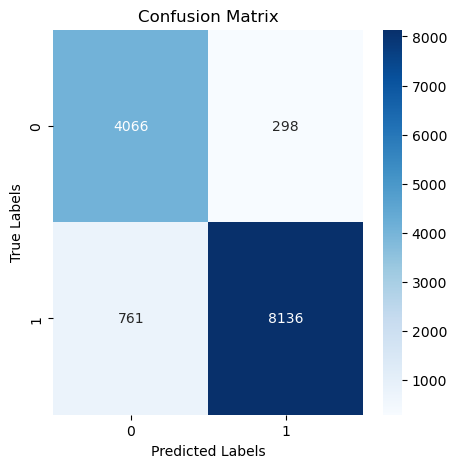

In [44]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

---------------------------------------------------------------Testing the model on the testing dataset--------------------------------------------------

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report


model = LogisticRegression(max_iter=1000, C=0.1, penalty="l2")

model.fit(X_train_bow, y_train)

y_test_pred = model.predict(X_test_bow)
y_test_pred_prob = model.predict_proba(X_test_bow)

accuracy = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, y_test_pred_prob)


print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss (Log Loss): {test_loss:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 92.26%
Test Loss (Log Loss): 0.2332
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4471
           1       0.97      0.92      0.94      8790

    accuracy                           0.92     13261
   macro avg       0.91      0.93      0.92     13261
weighted avg       0.93      0.92      0.92     13261



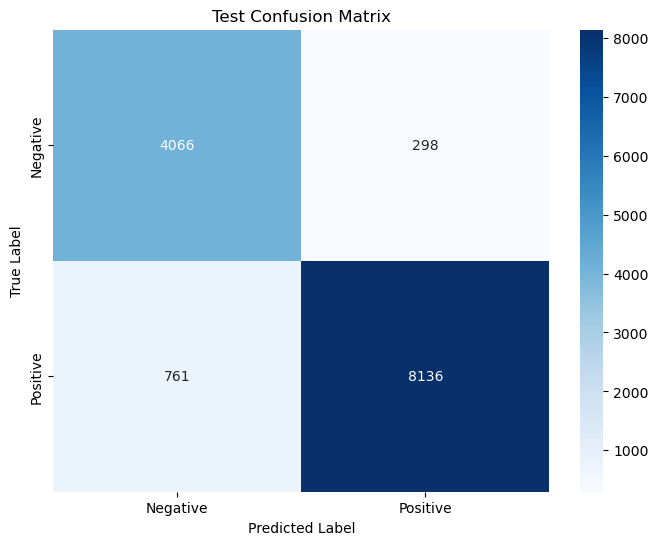

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

-----------------------------------------------------------Testing the logisitic regression model on new labels------------------------------------------

In [49]:
new_statements = [
    "I’ve been so nervous about the exams, I can’t stop worrying.",
    "I don’t think anyone understands how much pressure I am under right now.",
    "I am happy",  
    "I am excited",
    "I am Anxiety"
]

augmented_statements = []

for statement in new_statements:
    statement_synonym_replaced = synonym_replacement(statement)
    statement_swapped = random_swap(statement_synonym_replaced)
    statement_augmented = random_insertion(statement_swapped)
    augmented_statements.append(statement_augmented)

all_statements = new_statements + augmented_statements
all_statements_bow = vectorizer.transform(all_statements)

new_predictions = model.predict(all_statements_bow)

for statement, prediction in zip(all_statements, new_predictions):
    status = "Abnormal" if prediction == 1 else "Normal"
    print(f"Statement: {statement}")
    print(f"Predicted Status: {status}")
    print("-" * 50)


Statement: I’ve been so nervous about the exams, I can’t stop worrying.
Predicted Status: Abnormal
--------------------------------------------------
Statement: I don’t think anyone understands how much pressure I am under right now.
Predicted Status: Normal
--------------------------------------------------
Statement: I am happy
Predicted Status: Normal
--------------------------------------------------
Statement: I am excited
Predicted Status: Normal
--------------------------------------------------
Statement: I am Anxiety
Predicted Status: Abnormal
--------------------------------------------------
Statement: I’ve been so nervous amazingly about the exams, ace stop can’t worrying.
Predicted Status: Abnormal
--------------------------------------------------
Statement: incredibly now. don’t think anyone understands how much pressure I am under right I
Predicted Status: Normal
--------------------------------------------------
Statement: completely MA I happy
Predicted Status: Normal

----------------------------------------------------naive bayes model-----------------------------------------------------------------------------------

---------------------------------------------------------training and testing the model on validation----------------------------------------------------

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, log_loss
from imblearn.over_sampling import SMOTE

# Define custom class weights
custom_class_weights = {0: 3, 1:1}

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42, sampling_strategy='auto')

X_train_smote, y_train_smote = smote.fit_resample(X_train_bow, y_train)

# Initialize and train the Multinomial Naive Bayes model
nb_model = MultinomialNB(alpha=0.2, fit_prior=True)
nb_model.class_prior = [custom_class_weights[0], custom_class_weights[1]]  # Set class priors
nb_model.fit(X_train_smote, y_train_smote)

# Predictions and evaluations
y_val_pred = nb_model.predict(X_val_bow)
y_val_pred_prob = nb_model.predict_proba(X_val_bow)

# Calculate accuracy and log loss
accuracy = accuracy_score(y_val, y_val_pred)
val_loss = log_loss(y_val, y_val_pred_prob)

# Print results
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss (Log Loss): {val_loss:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 86.52%
Validation Loss (Log Loss): 0.8512
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      4364
           1       0.95      0.84      0.89      8897

    accuracy                           0.87     13261
   macro avg       0.85      0.88      0.86     13261
weighted avg       0.88      0.87      0.87     13261



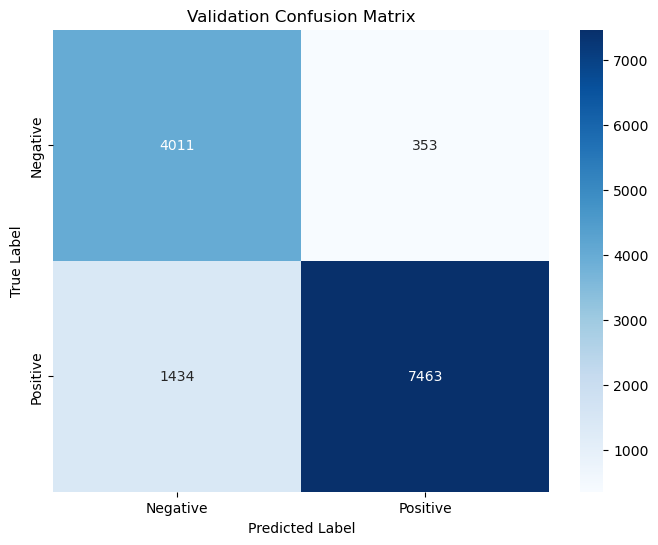

In [53]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

--------------------------------------------------------------trying the model on the test dataset------------------------------------------------------

In [55]:
# Predictions for the test set using the Naive Bayes model
y_test_pred = nb_model.predict(X_test_bow)
y_test_pred_prob = nb_model.predict_proba(X_test_bow)

# Calculate test accuracy and log loss
test_accuracy = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, y_test_pred_prob)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss (Log Loss): {test_loss:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 86.92%
Test Loss (Log Loss): 0.8546
Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      4471
           1       0.96      0.84      0.90      8790

    accuracy                           0.87     13261
   macro avg       0.85      0.88      0.86     13261
weighted avg       0.89      0.87      0.87     13261



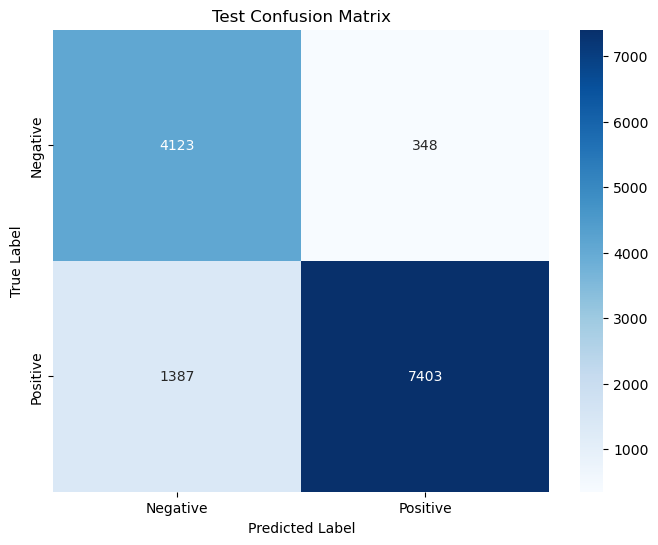

In [56]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

-----------------------------------------------------------Testing the naive bayes on new samples------------------------------------------------

In [63]:
import random
import string
import re
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Example data: define 'new_statements' with your raw statements
new_statements = [
    "I’ve been so nervous about the exams, I can’t stop worrying.",
    "I don’t think anyone understands how much pressure I am under right now.",
    "happy",
    "excited",
    "i want to die",
]

# Preprocess the statements
cleaned_statements = [preprocess_text(statement) for statement in new_statements]

# Assuming you already have your training data and labels
# For example, 'train_statements' contains your training text data and 'train_labels' contains the labels (0 or 1)
train_statements = data['feature'].tolist()  # Use your actual training data
train_labels = data['label'].tolist()  # Use your actual labels

# Initialize CountVectorizer and fit on the training data
vectorizer = CountVectorizer()
train_statements_bow = vectorizer.fit_transform(train_statements)

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(train_statements_bow, train_labels)

# Transform the cleaned new statements using the fitted vectorizer
new_statements_bow = vectorizer.transform(cleaned_statements)

# Predict the status of the new statements
new_status_pred = nb_model.predict(new_statements_bow)

# Print the statements and their predicted statuses
for statement, prediction in zip(new_statements, new_status_pred):
    print(f"Statement: {statement}")
    print(f"Predicted Status: {'Abnormal' if prediction == 1 else 'Normal'}\n")


Statement: I’ve been so nervous about the exams, I can’t stop worrying.
Predicted Status: Abnormal

Statement: I don’t think anyone understands how much pressure I am under right now.
Predicted Status: Abnormal

Statement: happy
Predicted Status: Abnormal

Statement: excited
Predicted Status: Normal

Statement: i want to die
Predicted Status: Abnormal

